# Bivariate Analysis of SIF and XCO2
---

In [1]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import seaborn as sns

## Data processing

In [103]:
def prep_sif(ds):
        dsnew = xarray.Dataset(
            {
                "sif": (["time"], ds.Daily_SIF_757nm),
            },
            coords={
                "lon": (["time"], ds.Longitude),
                "lat": (["time"], ds.Latitude),
                "time": ds.Delta_Time.values
            }
        )
        return dsnew
    
def prep_xco2(ds):
        dsnew = xarray.Dataset(
            {
                "xco2": (["time"], ds.xco2),
            },
            coords={
                "lon": (["time"], ds.longitude),
                "lat": (["time"], ds.latitude),
                "time": ds.time.values
            }
        )
        return dsnew
    
def aggregate_grid(ds):
    # Map lat-lon to 1-degree bins
    lon_bnds = np.arange(-180, 181)
    lat_bnds = np.arange(-85, 86)
    
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, lon_bnds, labels=np.arange(-179.5, 180.5)).astype(float)
    df["lat"] = pd.cut(df.lat, lat_bnds, labels=np.arange(-84.5, 85.5)).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lon", "lat"]).mean().to_xarray()

# def apply_ocean_mask(ds):
#     # Consider writing this so it returns a data array that can be assigned to dataset without needing to overwrite
#     # Create mask variable for *gridded* dataset {land: True, ocean: False}
#     land = regionmask.defined_regions.natural_earth.land_110
#     ds["ocean_mask"] = land.mask(ds)
#     ds.ocean_mask.values = ~np.array(ds.ocean_mask, dtype=bool)
#     return ds

In [36]:
# Open datasets for 2016
paths_sif = "../data/OCO2_L2_Lite_SIF_10r/2016/*.nc4"
paths_xco2 = "../data/OCO2_L2_Lite_FP_10r/2016/*.nc4"

DS_sif = xarray.open_mfdataset(paths_sif, preprocess=prep_sif, parallel=True)
DS_xco2 = xarray.open_mfdataset(paths_xco2, preprocess=prep_xco2, parallel=True)

In [131]:
# Aggregate both datasets to 1-degree monthly averages
DS_sif_monthly_grid = DS_sif.resample(time="1MS").map(aggregate_grid)
DS_xco2_monthly_grid = DS_xco2.resample(time="1MS").map(aggregate_grid)

In [164]:
# Create a data frame joining SIF and XCO2 by coordinates
df_sif = DS_sif_monthly_grid.to_dataframe().dropna()
df_xco2 = DS_xco2_monthly_grid.to_dataframe().dropna()
df = pd.merge(df_sif, df_xco2, how="inner", on=["lon", "lat", "time"]).reset_index()
df["time"] = df.time.dt.strftime("%Y-%m")
df.sort_values(by="time", inplace=True)

In [165]:
df.head()

,lon,lat,time,sif,xco2
64388,30.5,23.5,2016-01,0.018725,401.838074
79932,-90.5,34.5,2016-01,0.012832,403.838531
13406,86.5,-69.5,2016-01,0.035525,381.270477
50033,24.5,9.5,2016-01,0.026215,402.151642
13413,88.5,-69.5,2016-01,-0.178293,398.783447


## Bivariate analysis

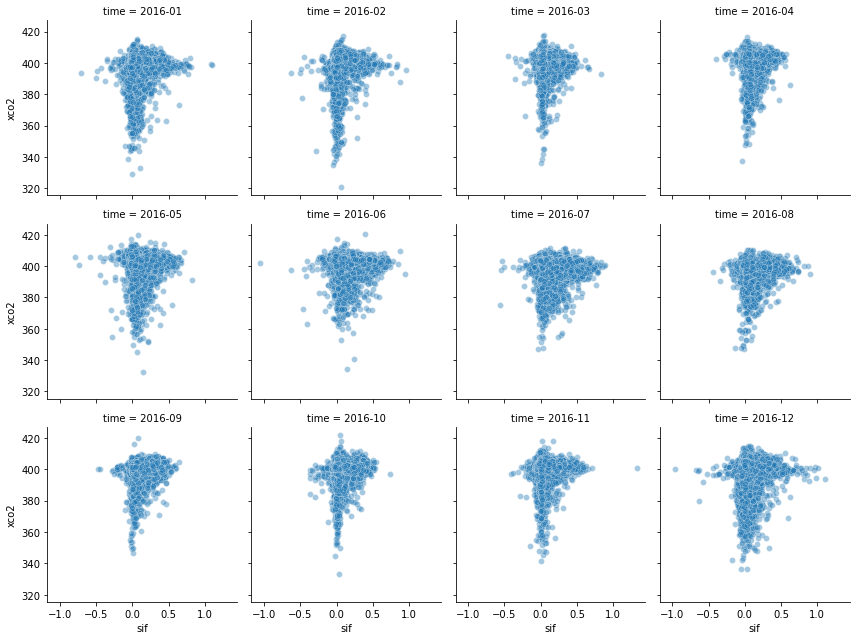

In [168]:
# Make scatter plots faceted by month
grid = sns.FacetGrid(df, col="time", col_wrap=4)
grid.map(sns.scatterplot, "sif", "xco2", alpha=0.4)
plt.tight_layout()
plt.savefig("../plots/bivariate_analysis_monthly_1-degree.png")